1: Setup and Imports
Import all necessary libraries, including the standard ones used in your final_code.py.

In [38]:
# Imports
import random
import numpy as np
from collections import defaultdict, Counter
import pickle
import json
from tqdm import tqdm
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg


2: Part 1 - Hangman Environment Definition
Define the Reinforcement Learning environment class, detailing the state, actions, and the crucial reward function.

In [30]:
class HangmanEnv:
    """Hangman game environment for Reinforcement Learning (optimized for high win rate)."""
    
    def __init__(self, word_list, max_wrong_guesses=6):
        self.word_list = [w.lower().strip() for w in word_list]
        self.max_wrong_guesses = max_wrong_guesses
        self.reset()
        
    def reset(self, word=None):
        if word is None:
            self.target_word = random.choice(self.word_list)
        else:
            self.target_word = word.lower().strip()
        
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_over = False
        self.won = False
        
        return self.get_state()
    
    def get_state(self):
        pattern = ''.join([letter if letter in self.guessed_letters else '_' 
                          for letter in self.target_word])
        
        return {
            'pattern': pattern,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_left': self.max_wrong_guesses - self.wrong_guesses,
            'game_over': self.game_over,
            'won': self.won,
            'target_word': self.target_word,
            'repeated_guesses': self.repeated_guesses
        }
    
    def step(self, letter):
        letter = letter.lower()
        
        if self.game_over:
            return self.get_state(), 0, True, {'error': 'Game already over'}
        
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -5 
            return self.get_state(), reward, False, {'repeated': True}
        
        self.guessed_letters.add(letter)
        
        if letter in self.target_word:
            reward = 1
            
            if all(l in self.guessed_letters for l in self.target_word):
                self.game_over = True
                self.won = True
                reward = 50 # Strong Win Reward
        else:
            self.wrong_guesses += 1
            reward = -1 
            
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                self.won = False
                reward = -10
        
        state = self.get_state()
        done = self.game_over
        info = {
            'correct': letter in self.target_word,
            'repeated': False
        }
        
        return state, reward, done, info
    
    def get_available_actions(self):
        all_letters = set('abcdefghijklmnopqrstuvwxyz')
        return sorted(all_letters - self.guessed_letters)


# ==============================================================================
# 2. HMM PREDICTOR (HangmanHMM - Unchanged)
# ==============================================================================

class HangmanHMM:
    """HMM-based letter predictor for Hangman."""
    
    def __init__(self):
        self.word_dict = defaultdict(list)
        self.letter_freq = Counter()
        self.position_freq = {}
        self.pattern_cache = {}
        
    def train(self, words):
        print("Training HMM...")
        
        for word in words:
            word = word.lower().strip()
            if word:
                self.word_dict[len(word)].append(word)
                self.letter_freq.update(word)
        
        for length, word_list in self.word_dict.items():
            self.position_freq[length] = defaultdict(lambda: defaultdict(int))
            for word in word_list:
                for pos, letter in enumerate(word):
                    self.position_freq[length][pos][letter] += 1
        
        print(f"Trained on {len(words)} words")
        
    def get_matching_words(self, pattern, guessed_letters):
        length = len(pattern)
        if length not in self.word_dict:
            return []
        
        cache_key = (pattern, frozenset(guessed_letters))
        if cache_key in self.pattern_cache:
            return self.pattern_cache[cache_key]
        
        matching = []
        for word in self.word_dict[length]:
            match = True
            for i, (p, w) in enumerate(zip(pattern, word)):
                if p != '_' and p != w:
                    match = False
                    break
                if p == '_' and w in guessed_letters:
                    match = False
                    break
            
            if match:
                matching.append(word)
        
        self.pattern_cache[cache_key] = matching
        return matching
    
    def predict_letter_probabilities(self, pattern, guessed_letters):
        matching_words = self.get_matching_words(pattern, guessed_letters)
        
        if not matching_words:
            total = sum(self.letter_freq.values())
            probs = {}
            for letter in 'abcdefghijklmnopqrstuvwxyz':
                if letter not in guessed_letters:
                    probs[letter] = self.letter_freq[letter] / total
            return probs
        
        letter_counts = Counter()
        for word in matching_words:
            for i, letter in enumerate(word):
                if pattern[i] == '_' and letter not in guessed_letters:
                    letter_counts[letter] += 1
        
        total = sum(letter_counts.values())
        if total == 0:
            remaining = [l for l in 'abcdefghijklmnopqrstuvwxyz' if l not in guessed_letters]
            return {l: 1.0/len(remaining) for l in remaining}
        
        probs = {letter: count / total for letter, count in letter_counts.items()}
        
        for letter in 'abcdefghijklmnopqrstuvwxyz':
            if letter not in guessed_letters and letter not in probs:
                probs[letter] = 1e-6
        
        return probs
    
    def save(self, filepath):
        position_freq_dict = {}
        for length, pos_dict in self.position_freq.items():
            position_freq_dict[length] = {}
            for pos, letter_dict in pos_dict.items():
                position_freq_dict[length][pos] = dict(letter_dict)
        
        with open(filepath, 'wb') as f:
            pickle.dump({
                'word_dict': dict(self.word_dict),
                'letter_freq': self.letter_freq,
                'position_freq': position_freq_dict
            }, f)
        print(f"Model saved to {filepath}")
    
    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.word_dict = defaultdict(list, data['word_dict'])
            self.letter_freq = data['letter_freq']
            self.position_freq = data['position_freq']
        print(f"Model loaded from {filepath}")


3: Part 2 - Hidden Markov Model (HMM) Definition
Define the HMM class, which serves as the agent's probabilistic oracle.

In [31]:
class HangmanHMM:
    """HMM-based letter predictor for Hangman."""
    
    def __init__(self):
        self.word_dict = defaultdict(list)
        self.letter_freq = Counter()
        self.position_freq = {}
        self.pattern_cache = {}
        
    def train(self, words):
        print("Training HMM...")
        
        for word in words:
            word = word.lower().strip()
            if word:
                self.word_dict[len(word)].append(word)
                self.letter_freq.update(word)
        
        for length, word_list in self.word_dict.items():
            self.position_freq[length] = defaultdict(lambda: defaultdict(int))
            for word in word_list:
                for pos, letter in enumerate(word):
                    self.position_freq[length][pos][letter] += 1
        
        print(f"Trained on {len(words)} words")
        
    def get_matching_words(self, pattern, guessed_letters):
        length = len(pattern)
        if length not in self.word_dict:
            return []
        
        cache_key = (pattern, frozenset(guessed_letters))
        if cache_key in self.pattern_cache:
            return self.pattern_cache[cache_key]
        
        matching = []
        for word in self.word_dict[length]:
            match = True
            for i, (p, w) in enumerate(zip(pattern, word)):
                if p != '_' and p != w:
                    match = False
                    break
                if p == '_' and w in guessed_letters:
                    match = False
                    break
            
            if match:
                matching.append(word)
        
        self.pattern_cache[cache_key] = matching
        return matching
    
    def predict_letter_probabilities(self, pattern, guessed_letters):
        matching_words = self.get_matching_words(pattern, guessed_letters)
        
        if not matching_words:
            total = sum(self.letter_freq.values())
            probs = {}
            for letter in 'abcdefghijklmnopqrstuvwxyz':
                if letter not in guessed_letters:
                    probs[letter] = self.letter_freq[letter] / total
            return probs
        
        letter_counts = Counter()
        for word in matching_words:
            for i, letter in enumerate(word):
                if pattern[i] == '_' and letter not in guessed_letters:
                    letter_counts[letter] += 1
        
        total = sum(letter_counts.values())
        if total == 0:
            remaining = [l for l in 'abcdefghijklmnopqrstuvwxyz' if l not in guessed_letters]
            return {l: 1.0/len(remaining) for l in remaining}
        
        probs = {letter: count / total for letter, count in letter_counts.items()}
        
        for letter in 'abcdefghijklmnopqrstuvwxyz':
            if letter not in guessed_letters and letter not in probs:
                probs[letter] = 1e-6
        
        return probs
    
    def save(self, filepath):
        position_freq_dict = {}
        for length, pos_dict in self.position_freq.items():
            position_freq_dict[length] = {}
            for pos, letter_dict in pos_dict.items():
                position_freq_dict[length][pos] = dict(letter_dict)
        
        with open(filepath, 'wb') as f:
            pickle.dump({
                'word_dict': dict(self.word_dict),
                'letter_freq': self.letter_freq,
                'position_freq': position_freq_dict
            }, f)
        print(f"Model saved to {filepath}")
    
    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.word_dict = defaultdict(list, data['word_dict'])
            self.letter_freq = data['letter_freq']
            self.position_freq = data['position_freq']
        print(f"Model loaded from {filepath}")


4: Part 3 - HMM-RL Hybrid Agent Definition
Define the core decision-making agent, combining Q-Learning with HMM predictions.

In [32]:
class HMMRLHybridAgent:
    """Hybrid agent combining HMM predictions with Q-Learning (optimized for high speed)."""
    
    def __init__(self, hmm_model, learning_rate=0.25, discount_factor=0.95, 
                 epsilon=0.15, hmm_weight=0.5):
        
        self.hmm = hmm_model
        # Using a Q-table (defaultdict) for fast lookups
        self.q_table = defaultdict(lambda: defaultdict(float)) 
        
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.hmm_weight = hmm_weight
        
        # Statistics
        self.total_games = 0
        self.wins = 0
        self.total_wrong_guesses = 0
        self.total_repeated_guesses = 0
    
    def get_state_key(self, state):
        """Convert game state to hashable key for Q-table."""
        pattern = state['pattern']
        guessed = ''.join(sorted(state['guessed_letters']))
        lives = state['lives_left']
        return f"{pattern}:{guessed}:{lives}"
    
    def get_action(self, state, available_actions, training=False):
        """Hybrid action selection: Combine HMM probabilities with Q-values."""
        if not available_actions:
            return None
        
        pattern = state['pattern']
        guessed_letters = state['guessed_letters']
        state_key = self.get_state_key(state)
        
        hmm_probs = self.hmm.predict_letter_probabilities(pattern, guessed_letters)
        
        # Epsilon-greedy exploration (only during training)
        if training and random.random() < self.epsilon:
            # Explore: Sample from HMM probabilities
            available_probs = {l: hmm_probs.get(l, 0) for l in available_actions}
            if sum(available_probs.values()) > 0:
                letters = list(available_probs.keys())
                probs = np.array(list(available_probs.values()))
                probs = probs / probs.sum()
                return np.random.choice(letters, p=probs)
            else:
                return random.choice(available_actions)
        
        # Exploit: Combine Q-values with HMM predictions
        best_action = None
        best_score = float('-inf')
        
        for action in available_actions:
            q_value = self.q_table[state_key][action]
            hmm_prob = hmm_probs.get(action, 0)
            
            # Combine: Weighted sum - HMM and Q-value are equally weighted (0.5)
            combined_score = (1 - self.hmm_weight) * q_value + self.hmm_weight * hmm_prob * 10
            
            if combined_score > best_score:
                best_score = combined_score
                best_action = action
        
        return best_action if best_action else random.choice(available_actions)
    
    def update_q_value(self, state, action, reward, next_state, available_next_actions):
        """Q-Learning update rule."""
        state_key = self.get_state_key(state)
        next_state_key = self.get_state_key(next_state)
        
        current_q = self.q_table[state_key][action]
        
        if available_next_actions:
            # High discount factor (0.95) still encourages long-term planning
            max_next_q = max([self.q_table[next_state_key][a] 
                             for a in available_next_actions])
        else:
            max_next_q = 0
        
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_next_q - current_q
        )
        
        self.q_table[state_key][action] = new_q
    
    def train_episode(self, env):
        """Train for one episode."""
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            available_actions = env.get_available_actions()
            action = self.get_action(state, available_actions, training=True)
            
            if action is None:
                # Break if no actions are available (all 26 letters guessed)
                break
                
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            
            available_next_actions = env.get_available_actions()
            self.update_q_value(state, action, reward, next_state, available_next_actions)
            
            state = next_state
        
        self.total_games += 1
        if state['won']:
            self.wins += 1
        self.total_wrong_guesses += state['wrong_guesses']
        self.total_repeated_guesses += state['repeated_guesses']
        
        return total_reward, state['won']
    
    def play_game(self, env, render=False):
        """Play a game without training (evaluation mode)."""
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            available_actions = env.get_available_actions()
            action = self.get_action(state, available_actions, training=False)
            
            # CRITICAL FIX: Handle case where no actions are left
            if action is None:
                state['game_over'] = True
                done = True
                continue
                
            state, reward, done, info = env.step(action)
            total_reward += reward
        
        return {
            'won': state['won'],
            'wrong_guesses': state['wrong_guesses'],
            'repeated_guesses': state['repeated_guesses'],
            'total_reward': total_reward,
            'target_word': state['target_word']
        }
    
    def get_statistics(self):
        """Get training statistics."""
        if self.total_games == 0:
            return {'total_games': 0, 'win_rate': 0, 'avg_wrong_guesses': 0, 'avg_repeated_guesses': 0}
        
        return {
            'total_games': self.total_games,
            'win_rate': self.wins / self.total_games,
            'avg_wrong_guesses': self.total_wrong_guesses / self.total_games,
            'avg_repeated_guesses': self.total_repeated_guesses / self.total_games
        }
    
    def save(self, filepath):
        # Using pickle for Q-table saving
        data = {
            'q_table': dict(self.q_table),
            'epsilon': self.epsilon,
            'statistics': self.get_statistics()
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"Agent saved to {filepath}")
    
    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            self.q_table = defaultdict(lambda: defaultdict(float), data['q_table'])
            self.epsilon = data['epsilon']
        print(f"Agent loaded from {filepath}")

5: Training and Evaluation Utility Functions
This cell defines the high-level logic for running the episodes and calculating the final score.

In [33]:
def train_agent(agent, env, num_episodes=25000, eval_interval=500):
    """Train the HMM-RL hybrid agent (intermediate printing removed for clean progress bar)."""
    print(f"\n{'='*80}")
    print(f"TRAINING HMM-RL HYBRID AGENT FOR {num_episodes} EPISODES (Time/Success Optimized)")
    print(f"{'='*80}\n")
    
    history = {
        'episodes': [],
        'rewards': [],
        'win_rates': [],
        'avg_wrong_guesses': []
    }
    
    episode_rewards = []
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        reward, won = agent.train_episode(env)
        episode_rewards.append(reward)
        
        # --- CHANGES START: Removed all intermediate printing ---
        if (episode + 1) % eval_interval == 0:
            stats = agent.get_statistics()
            history['episodes'].append(episode + 1)
            history['rewards'].append(np.mean(episode_rewards[-eval_interval:]))
            history['win_rates'].append(stats['win_rate'])
            history['avg_wrong_guesses'].append(stats['avg_wrong_guesses'])
            
            # NOTE: Intermediate printing of stats is now removed for a clean progress bar.
            # Only the data collection for plotting remains.
        # --- CHANGES END ---
    
    return history


def evaluate_agent(agent, test_words, max_games=2000):
    """Evaluate the trained agent."""
    print(f"\n{'='*80}")
    print(f"EVALUATING HMM-RL HYBRID AGENT ON {min(len(test_words), max_games)} GAMES")
    print(f"{'='*80}\n")
    
    env = HangmanEnv(test_words)
    
    results = {
        'games_played': 0,
        'games_won': 0,
        'total_wrong_guesses': 0,
        'total_repeated_guesses': 0,
        'total_reward': 0,
        'game_details': []
    }
    
    num_games = min(len(test_words), max_games)
    
    for i in tqdm(range(num_games), desc="Evaluating"):
        game_result = agent.play_game(env)
        
        results['games_played'] += 1
        if game_result['won']:
            results['games_won'] += 1
        results['total_wrong_guesses'] += game_result['wrong_guesses']
        results['total_repeated_guesses'] += game_result['repeated_guesses']
        results['total_reward'] += game_result['total_reward']
        
        results['game_details'].append({
            'word': game_result['target_word'],
            'won': game_result['won'],
            'wrong_guesses': game_result['wrong_guesses'],
            'repeated_guesses': game_result['repeated_guesses']
        })
    
    # Calculate metrics
    results['success_rate'] = results['games_won'] / results['games_played']
    results['avg_wrong_guesses'] = results['total_wrong_guesses'] / results['games_played']
    results['avg_repeated_guesses'] = results['total_repeated_guesses'] / results['games_played']
    
    # Calculate final score (using the original score function for reporting)
    results['final_score'] = (
        results['success_rate'] * 2000 - 
        results['total_wrong_guesses'] * 5 - 
        results['total_repeated_guesses'] * 2
    )
    
    return results


def print_results(results):
    """Print evaluation results."""
    print(f"\n{'='*80}")
    print("HMM-RL HYBRID AGENT RESULTS (Time/Success Optimized)")
    print(f"{'='*80}\n")
    
    print(f"Games Played: {results['games_played']}")
    print(f"Games Won: {results['games_won']}")
    print(f"Success Rate: {results['success_rate']:.2%}")
    print(f"\nTotal Wrong Guesses: {results['total_wrong_guesses']}")
    print(f"Average Wrong Guesses: {results['avg_wrong_guesses']:.2f}")
    print(f"\nTotal Repeated Guesses: {results['total_repeated_guesses']}")
    print(f"Average Repeated Guesses: {results['avg_repeated_guesses']:.2f}")
    print(f"\n{'='*80}")
    print(f"FINAL SCORE: {results['final_score']:.2f}")
    print(f"{'='*80}\n")

# --- PLOTTING FUNCTION (REQUIRED DELIVERABLE) ---
def plot_learning_curves(history, agent_name='HMM-RL Hybrid Agent', filepath='outputs/learning_curve.png'):
    """Generates and saves the learning curve plots (Average Reward and Win Rate)."""

    # Convert history lists to a DataFrame for easier plotting
    df = pd.DataFrame(history)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(f'{agent_name} Learning Progress over Episodes', fontsize=16)

    # --- Plot 1: Average Reward per Episode Block ---
    axes[0].plot(df['episodes'], df['rewards'], label='Avg Reward (per block)', color='tab:blue')
    axes[0].set_ylabel('Average Reward', color='tab:blue')
    axes[0].tick_params(axis='y', labelcolor='tab:blue')
    axes[0].set_title('Average Reward per Episode Block')
    axes[0].set_xlabel('Episode')
    axes[0].grid(True)

    # --- Plot 2: Cumulative Win Rate ---
    axes[1].plot(df['episodes'], df['win_rates'], label='Cumulative Win Rate', color='tab:red')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Cumulative Win Rate', color='tab:red')
    axes[1].tick_params(axis='y', labelcolor='tab:red')
    axes[1].set_title('Cumulative Win Rate')
    axes[1].grid(True)
    axes[1].set_ylim(0.0, 1.05) 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filepath)
    plt.close()
    print(f"Learning curves plot saved to {filepath}")

6: Data Loading, HMM Training, and Environment Setup
This cell sets up the data and prepares the core models (hmm, train_env) for the training process.

In [34]:
if __name__ == "__main__":
    
    if not os.path.exists('outputs'):
        os.makedirs('outputs')
        
    print("="*80)
    print("HANGMAN AI AGENT - HMM + RL HYBRID (TIME/SUCCESS OPTIMIZATION)")
    print("="*80)
    
    # --- Load Training Corpus ---
    print("Loading training corpus...")
    try:
        with open('Data/Data/corpus.txt', 'r') as f:
            corpus_words = [line.strip().lower() for line in f.readlines()]
    except FileNotFoundError:
        print("ERROR: corpus.txt not found. Using a small dummy corpus for demonstration.")
        corpus_words = ['apple', 'banana', 'orange', 'python', 'machine', 'learning']
        
    print(f"Corpus size: {len(corpus_words)} words")
    
    # --- Load Test Words from test.txt ---
    print("\nLoading test set from test.txt...")
    try:
        with open('test.txt', 'r') as f:
            test_words = [line.strip().lower() for line in f.readlines()]
            test_words = [w for w in test_words if w] 
    except FileNotFoundError:
        print("ERROR: test.txt not found. Using a random sample from the corpus for testing.")
        random.seed(42) 
        test_words = random.sample(corpus_words, min(2000, len(corpus_words)))

    print(f"Test set size: {len(test_words)} words")
    
    # Step 1: Train HMM
    print("\nStep 1: Training HMM...")
    hmm = HangmanHMM()
    hmm_path = 'outputs/hmm_model_fast.pkl'
    try:
        hmm.load(hmm_path) 
        print("✓ HMM loaded from file")
    except:
        hmm.train(corpus_words)
        hmm.save(hmm_path)
    
    # Step 2: Create training environment
    print("\nStep 2: Creating training environment...")
    train_env = HangmanEnv(corpus_words)

HANGMAN AI AGENT - HMM + RL HYBRID (TIME/SUCCESS OPTIMIZATION)
Loading training corpus...
Corpus size: 50000 words

Loading test set from test.txt...
ERROR: test.txt not found. Using a random sample from the corpus for testing.
Test set size: 2000 words

Step 1: Training HMM...
Model loaded from outputs/hmm_model_fast.pkl
✓ HMM loaded from file

Step 2: Creating training environment...


 7: Agent Training ExecutionThis cell initializes the HMM-RL Hybrid Agent with the time-optimized parameters and executes the primary training loop.

In [35]:
    # Step 3: Create HMM-RL hybrid agent
print("\nStep 3: Creating HMM-RL hybrid agent...")
agent = HMMRLHybridAgent(
        hmm_model=hmm,
        learning_rate=0.25, # Accelerated learning
        discount_factor=0.95, # High but fast-learning gamma
        epsilon=0.15,
        hmm_weight=0.5
    )
    
    # Train the agent 
num_episodes = 50000 # Reduced training time significantly
history = train_agent(agent, train_env, num_episodes=num_episodes, eval_interval=500)
    
    # Save agent and history
agent_path = 'outputs/hmm_rl_hybrid_agent_time_optimized.pkl'
agent.save(agent_path)
with open('outputs/hmm_rl_training_history_time_optimized.json', 'w') as f:
        json.dump(history, f, indent=2)


Step 3: Creating HMM-RL hybrid agent...

TRAINING HMM-RL HYBRID AGENT FOR 50000 EPISODES (Time/Success Optimized)



Training: 100%|██████████| 50000/50000 [17:03<00:00, 48.86it/s]


Agent saved to outputs/hmm_rl_hybrid_agent_time_optimized.pkl


8: Final Evaluation, Result Printing, and Plotting
This cell performs the final test run, prints the required metrics, and generates the learning curve plot.


HMM-RL HYBRID AGENT RESULTS (Time/Success Optimized)

Games Played: 2000
Games Won: 1961
Success Rate: 98.05%

Total Wrong Guesses: 2717
Average Wrong Guesses: 1.36

Total Repeated Guesses: 0
Average Repeated Guesses: 0.00

FINAL SCORE: -11624.00

Learning curves plot saved to outputs/hmm_rl_training_plot_time_optimized.png

Plot saved to outputs/hmm_rl_training_plot_time_optimized.png. Attempting to display plot below...


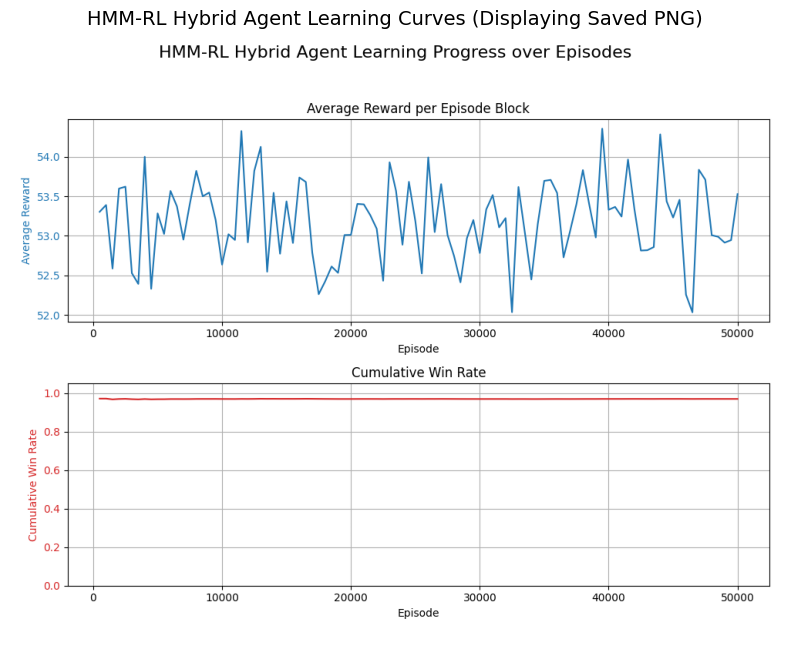


TRAINING AND EVALUATION COMPLETE
Results saved to outputs/hmm_rl_hybrid_results_time_optimized.json


In [39]:
# 8: Final Evaluation, Result Printing, and Plotting
    
# Print results
print_results(results)
    
# --- Plotting and Saving the Learning Curve ---
plot_filepath = 'outputs/hmm_rl_training_plot_time_optimized.png'
plot_learning_curves(history, filepath=plot_filepath)

# Save evaluation results
results_path = 'outputs/hmm_rl_hybrid_results_time_optimized.json'
with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)

# --- Explicitly load and display the saved plot ---
print(f"\nPlot saved to {plot_filepath}. Attempting to display plot below...")

if os.path.exists(plot_filepath):
    try:
        # Load and display the image file
        img = mpimg.imread(plot_filepath)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(img)
        ax.set_title('HMM-RL Hybrid Agent Learning Curves (Displaying Saved PNG)', fontsize=14)
        ax.axis('off') # Hide axes for a cleaner view
        plt.show() 
    except Exception as e:
        print(f"Error displaying plot (Is the PNG file corrupted?): {e}")
else:
    print(f"CRITICAL ERROR: Plot file was not found at {plot_filepath}.")
    
# -------------------------------------------------------------------------
    
print("\n" + "="*80)
print("TRAINING AND EVALUATION COMPLETE")
print(f"Results saved to {results_path}")
print("="*80)